In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

La función load_and_preprocess_data encapsula el proceso de carga, preprocesamiento y división del conjunto de datos, promoviendo la modularidad y reutilización del código.  Inicialmente, se cargan los datos desde un archivo CSV utilizando pandas, y se separan las características (X) de las etiquetas (y).  Posteriormente, se realiza un escalado de las características mediante StandardScaler para asegurar que todas las variables contribuyan equitativamente al entrenamiento del modelo.  Las etiquetas, que representan los géneros musicales, se codifican a valores numéricos con LabelEncoder, ya que las redes neuronales operan con datos numéricos.  Finalmente, los datos se convierten a tensores de PyTorch y se dividen en conjuntos de entrenamiento y prueba, preparando los datos para el entrenamiento y evaluación de los modelos.  Los DataLoaders se crean para facilitar la iteración eficiente sobre los datos en lotes durante el entrenamiento.

In [2]:
def load_and_preprocess_data(csv_file='features_3_sec.csv'):
    """Carga, preprocesa y divide el dataset."""

    data = pd.read_csv(csv_file)
    X = data.drop(['filename', 'label'], axis=1).values
    y = data['label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_encoded, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = train_test_split(dataset, train_size=train_size, test_size=test_size)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, le

Este bloque define las arquitecturas de los modelos autoencoder (AE), autoencoder denoising (DAE) y perceptrón multicapa (MLP) utilizando las clases de PyTorch.  El Autoencoder está compuesto por un encoder que reduce la dimensionalidad de la entrada a una representación latente, y un decoder que reconstruye la entrada a partir de esta representación.  El DenoisingAutoencoder extiende esta arquitectura introduciendo ruido a la entrada durante el entrenamiento, lo que fuerza al modelo a aprender representaciones más robustas.  Ambos modelos utilizan capas lineales y funciones de activación ReLU para realizar las transformaciones.  Por otro lado, el MLP es un clasificador que consta de varias capas lineales con funciones de activación ReLU y capas de dropout para prevenir el sobreajuste.  La capa final del MLP tiene una dimensión igual al número de clases, lo que permite realizar la clasificación entre los géneros musicales.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

In [4]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.1
        x_noisy = x + noise
        encoded = self.encoder(x_noisy)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)



In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

La función train_autoencoder implementa el proceso de entrenamiento para los modelos autoencoder.  Recibe como entrada el modelo a entrenar (AE o DAE), el train_loader que proporciona los datos de entrenamiento en lotes, la función de pérdida (criterion), el optimizador y el número de épocas.  Durante cada época, el modelo procesa cada lote de datos, calcula la pérdida entre la entrada y la reconstrucción, y actualiza los pesos del modelo mediante el algoritmo de retropropagación.  El optimizador se encarga de ajustar los pesos para minimizar la pérdida.  Es importante destacar que los autoencoders se entrenan de manera no supervisada, utilizando la entrada como objetivo de reconstrucción.  Al final de cada época, se imprime la pérdida de entrenamiento para monitorear el progreso del modelo.

In [6]:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs, model_name="AE"):

    for epoch in range(num_epochs):
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss {model_name}: {loss.item():.4f}')


La función train_mlp se encarga de entrenar y evaluar el modelo MLP utilizando las características extraídas por los autoencoders.  A diferencia del entrenamiento de los autoencoders, aquí el MLP se entrena de forma supervisada, utilizando las etiquetas de los géneros musicales.  En cada iteración, se obtienen las representaciones latentes de los datos de entrenamiento utilizando la función encode del autoencoder correspondiente.  Estas representaciones latentes se utilizan como entrada para el MLP, que realiza la clasificación.  Se calcula la pérdida utilizando CrossEntropyLoss, se realiza la retropropagación y se actualizan los pesos del MLP.  Además del entrenamiento, la función también realiza la evaluación del modelo en el conjunto de prueba, calculando métricas como el reporte de clasificación y la precisión.  Finalmente, se genera una curva de pérdida que muestra la evolución del error durante el entrenamiento.

In [7]:
def train_mlp(model_mlp, autoencoder, train_loader, test_loader, le, criterion, optimizer, num_epochs, model_name="AE"):
    """Entrena el MLP con las características extraídas por el Autoencoder."""

    train_losses = []

    for epoch in range(num_epochs):
        model_mlp.train()
        running_loss = 0.0
        for data, labels in train_loader:
            # Obtener representaciones latentes del Autoencoder
            with torch.no_grad():
                latent_representations = autoencoder.encode(data)

            optimizer.zero_grad()
            outputs = model_mlp(latent_representations)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss MLP ({model_name}): {epoch_loss:.4f}')

    # Evaluación
    model_mlp.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            latent_representations = autoencoder.encode(data)
            outputs = model_mlp(latent_representations)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nClassification Report ({model_name}):")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))
    print(f"Accuracy ({model_name}):", accuracy_score(all_labels, all_preds))

    # Curva de Pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label=f'Training Loss ({model_name})', color='red')
    plt.title(f'Training Loss Curve ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



Este bloque de código contiene la lógica principal de ejecución del programa.  Inicialmente, se cargan y preprocesan los datos, obteniendo los DataLoaders y el LabelEncoder.  Se definen los parámetros clave del modelo y el entrenamiento, como la dimensión de la representación latente, el número de clases, el número de épocas y las tasas de aprendizaje.  Se instancian los modelos AE, DAE y MLP, y se definen las funciones de pérdida y los optimizadores correspondientes.  A continuación, se entrenan los autoencoders utilizando la función train_autoencoder.  Finalmente, se entrenan y evalúan dos instancias separadas del MLP, una con las representaciones latentes del AE y otra con las del DAE, lo que permite comparar el rendimiento de ambos modelos autoasociativos como extractores de características.  El uso de if __name__ == '__main__': asegura que este bloque de código se ejecute solo cuando el script se ejecuta directamente y no cuando se importa como módulo.

Epoch [1/50], Loss AE: 0.2407
Epoch [2/50], Loss AE: 0.1822
Epoch [3/50], Loss AE: 0.1326
Epoch [4/50], Loss AE: 0.0881
Epoch [5/50], Loss AE: 0.0894
Epoch [6/50], Loss AE: 0.0691
Epoch [7/50], Loss AE: 0.0516
Epoch [8/50], Loss AE: 0.0615
Epoch [9/50], Loss AE: 0.0544
Epoch [10/50], Loss AE: 0.0310
Epoch [11/50], Loss AE: 0.0297
Epoch [12/50], Loss AE: 0.0337
Epoch [13/50], Loss AE: 0.0287
Epoch [14/50], Loss AE: 0.0243
Epoch [15/50], Loss AE: 0.0214
Epoch [16/50], Loss AE: 0.0187
Epoch [17/50], Loss AE: 0.0232
Epoch [18/50], Loss AE: 0.0185
Epoch [19/50], Loss AE: 0.0173
Epoch [20/50], Loss AE: 0.0125
Epoch [21/50], Loss AE: 0.0125
Epoch [22/50], Loss AE: 0.0185
Epoch [23/50], Loss AE: 0.0109
Epoch [24/50], Loss AE: 0.0120
Epoch [25/50], Loss AE: 0.0101
Epoch [26/50], Loss AE: 0.0106
Epoch [27/50], Loss AE: 0.0110
Epoch [28/50], Loss AE: 0.0083
Epoch [29/50], Loss AE: 0.0086
Epoch [30/50], Loss AE: 0.0124
Epoch [31/50], Loss AE: 0.0066
Epoch [32/50], Loss AE: 0.0086
Epoch [33/50], Lo

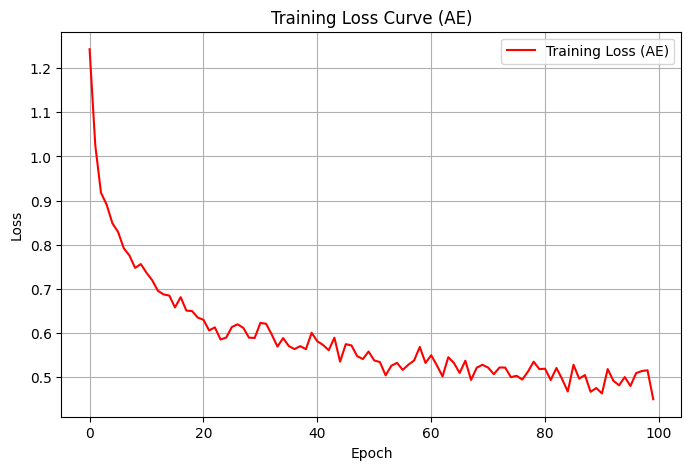

Epoch [1/100], Loss MLP (DAE): 1.2109
Epoch [2/100], Loss MLP (DAE): 0.9669
Epoch [3/100], Loss MLP (DAE): 0.8678
Epoch [4/100], Loss MLP (DAE): 0.8667
Epoch [5/100], Loss MLP (DAE): 0.8019
Epoch [6/100], Loss MLP (DAE): 0.7582
Epoch [7/100], Loss MLP (DAE): 0.7302
Epoch [8/100], Loss MLP (DAE): 0.6978
Epoch [9/100], Loss MLP (DAE): 0.6917
Epoch [10/100], Loss MLP (DAE): 0.6856
Epoch [11/100], Loss MLP (DAE): 0.6819
Epoch [12/100], Loss MLP (DAE): 0.6547
Epoch [13/100], Loss MLP (DAE): 0.6560
Epoch [14/100], Loss MLP (DAE): 0.6478
Epoch [15/100], Loss MLP (DAE): 0.6485
Epoch [16/100], Loss MLP (DAE): 0.6409
Epoch [17/100], Loss MLP (DAE): 0.6123
Epoch [18/100], Loss MLP (DAE): 0.6127
Epoch [19/100], Loss MLP (DAE): 0.5853
Epoch [20/100], Loss MLP (DAE): 0.5674
Epoch [21/100], Loss MLP (DAE): 0.5576
Epoch [22/100], Loss MLP (DAE): 0.5674
Epoch [23/100], Loss MLP (DAE): 0.5787
Epoch [24/100], Loss MLP (DAE): 0.5451
Epoch [25/100], Loss MLP (DAE): 0.5658
Epoch [26/100], Loss MLP (DAE): 0.

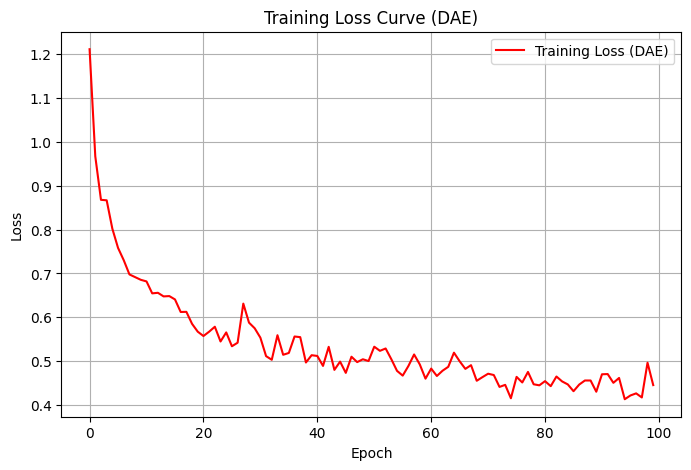

In [8]:
if __name__ == '__main__':

    train_loader, test_loader, le = load_and_preprocess_data()
    input_dim = next(iter(train_loader))[0].shape[1]

    # Parámetros
    latent_dim = 64
    num_classes = len(le.classes_)
    num_epochs_ae = 50
    num_epochs_mlp = 100
    lr_ae = 0.001
    lr_mlp = 0.01

    # Modelos
    model_ae = Autoencoder(input_dim, latent_dim)
    model_dae = DenoisingAutoencoder(input_dim, latent_dim)
    model_mlp = MLP(latent_dim, num_classes)

    # Criterios y Optimizadores
    criterion_ae = nn.MSELoss()
    optimizer_ae = optim.Adam(model_ae.parameters(), lr=lr_ae)
    criterion_mlp = nn.CrossEntropyLoss()
    optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=lr_mlp)

    # Entrenar Autoencoders
    train_autoencoder(model_ae, train_loader, criterion_ae, optimizer_ae, num_epochs_ae, model_name="AE")
    train_autoencoder(model_dae, train_loader, criterion_ae, optim.Adam(model_dae.parameters(), lr=lr_ae), num_epochs_ae, model_name="DAE")


    model_mlp_ae = MLP(latent_dim, num_classes)
    train_mlp(model_mlp_ae, model_ae, train_loader, test_loader, le, criterion_mlp, optim.Adam(model_mlp_ae.parameters(), lr=lr_mlp), num_epochs_mlp, model_name="AE")


    model_mlp_dae = MLP(latent_dim, num_classes)
    train_mlp(model_mlp_dae, model_dae, train_loader, test_loader, le, criterion_mlp, optim.Adam(model_mlp_dae.parameters(), lr=lr_mlp), num_epochs_mlp, model_name="DAE")